# Tutorial 3: Evaporation tutorial

## Explicit solvent

In this tutorial, we will set up a evaporation simulation of a mixture of a solvent with some solutes. For simplicity, we'll use spherical colloids (green), which are larger as the solvent particles (grey) with a diameter of`s_A`$=\sigma_A=4$ and a mass of $m_A=4^3$. The solvent particle diameter `s_S`$=\sigma_s=1$ defines the unit of length, and it's mass is set to $m=1$. The simulation box will be periodic in $x$ and $y$, and have a wall (black) in $z$ direction, the evaporation direction. Because the system will be set up as shown in the sketch, we will have a liquid film on top of the wall with a coexisting vapor above it. Evaporation is realized by deleting particles periodically in the deletion zone (slab in $z$ direction at the top, yellow). Because the system might exhibit evaporative cooling, we will also thermostat a small region (also a slab in $z$ direction, red) close to the wall. 

![system_sketch_explicit](system_sketch_explicit.png)

### System setup
We initialized and equilibrated the particles in a box with densities $\rho_s=0.3$ `rho_S` and  $\rho_A=0.01$ `rho_A`. The temperature `kT` is set to 1.0. The initial liquid film height `height` is 40 in a box of total height `Lz=60`, and temperature `kT`. Particle type `A` or typeid `0` is the larger colloid A, and `S` or typeid `1` is the solvent.

```Python
import numpy as np
import sys
import hoomd
from hoomd import md
from hoomd import data
import azplugins

kT = 1.0
Lz = 60
hoomd.context.initialize()
hoomd.context.SimulationContext()

system = hoomd.init.read_gsd(filename='tutorial_02_explicit_evaporation_init.gsd',time_step=0)

s_S = 1.0
s_A = 4.0
s_AS = 0.5*(s_A+s_S)

```

You can see that in addition to the colloid `A` and the solvent `S`, we defined some particle types `T` and `Z`, which will be used for thermostatting and deleting later on. For now we need to define all interactions in the system. All pair interactions with the solvent are described attractive LJ potentials with a cut off ``r_cut``$=3\sigma_i$ and onset of smoothing at ``r_on``$=2.5\sigma_i$. All colloid interactions are purely repulsive WCA pair potentials, cut at $2^{1/6}\sigma_i$.  

```Python
nl = hoomd.md.nlist.tree()
lj = hoomd.md.pair.lj(nlist=nl,r_cut =3.0*s_AS,name='n')
lj.set_params(mode="xplor")
lj.pair_coeff.set(['S','T'], ['S','T'], epsilon=1.0, sigma=s_S, r_cut=3.0*s_S,      r_on=2.5*s_S)
lj.pair_coeff.set(['S','T'], 'A', epsilon=1.0, sigma=s_AS,r_cut=3.0*s_AS,     r_on=2.5*s_AS)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=s_A, r_cut=2**(1/6.)*s_A,r_on=2.5*s_A)
lj.pair_coeff.set('Z', ['A','S','Z','T'], epsilon=0, sigma=0, r_cut=False)

lower_wall=hoomd.md.wall.group()
lower_wall.add_plane((0,0,-Lz/2.), (0,0,1))
lj_wall_lo=azplugins.wall.lj93(lower_wall, r_cut=3.0*s_A,name='wall')
lj_wall_lo.force_coeff.set('A', epsilon=2.0, sigma=s_A, r_cut=3.0*s_A)
lj_wall_lo.force_coeff.set(['S','T','Z'], epsilon=2.0, sigma=s_S,  r_cut=3.0*s_S)

upper_wall=hoomd.md.wall.group()
upper_wall.add_plane((0,0,Lz/2.), (0,0,-1))
lj_wall_up=azplugins.wall.lj93(upper_wall, r_cut=s_A*(2/5.)**(1/6.))
lj_wall_up.force_coeff.set('A', epsilon=2.0, sigma=s_A, r_cut=(2/5.)**(1/6.)*s_A)
lj_wall_up.force_coeff.set(['S','T','Z'], epsilon=2.0, sigma=s_S,  r_cut=(2/5.)**(1/6.)*s_S)

```
We use a Lennard-Jones 9-3 potential for the walls, attractive at the bottom, purely repulsive at the top (cut at $(2/5)^{1/6.}\sigma_i$).`S` and `T` particles are identical, except for the fact that `T` will be coupled to the thermostat later on, so all their pair interactions are the same. The larger colloids `A` are four times as big as the solvent `S` particles, and all pair potential values are adjusted accordingly to their respective diameters. The `Z` particles represent deleted particles, so they do not interact with any particle in the system. 

### Evaporation

Now, we need to set up the evaporation. 

```Python
azplugins.update.types(inside='T', outside='S', lo=-Lz/2., hi=-Lz/2.+2, period=1)
langevin.set_gamma('T', gamma=0.1)
langevin.set_gamma('S', gamma=0.0)
evap = azplugins.evaporate.particles(solvent='S', evaporated='Z', lo=Lz/2.-2, hi=Lz/2., seed=77, period=1)

```

Here, we use ``azplugins.update.types`` to define a region where the particle types will be switched from `S` to `T` if solvent particles enter it, and swiched back when they leave it. Then, we set the friction coefficents  $\gamma=$ `gamma`  of the two particles such that only `T` particles are weakly coupled and `S` particles are not. 

The actual evaporation is also a particle type switch, this time non-reversible, from `S` to `Z`, a ghost particle. Because they don't interact with any particle in the system, they are effectively removed from the system. If you have very long or big evaporation simulations, it can be beneficial to periodically remove all `Z` particles by stopping the simulation, taking a snapshot `system.take_snapshot()`, deleting all `Z`, and then reading it back in via `system.restore_snapshot()`. See `hoomd.data` [interface](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-data.html) for more details.

Because evaporated particles are not removed from the simulation box, the temperature, pressure, etc. reported by `hoomd.compute.thermo` will not be meaningful. (Their degrees of freedom are still included in calculations.) This is OK because evaporation is a nonequilibrium process, and care should be taken in defining these quantities anyway.
If necessary, make sure that you compute these properties in post-processing.
            
Both ``azplugins.update.types``  and ``azplugins.evaporate.particles`` take ``lo`` and ``hi`` as parameters, defining the upper and lower boundary of the region. They have to be inside the simulation box and if they overlap, it is the users responsibilty to ensure that the system makes physical sense. The parameter `period` is used to determine how frequent the update should be performed. 

### Evaporation parameters

`solvent` is the solvent particle type and `evaporated` is the evaporated, or ghost, particle type. The region is defined by `lo`,the lower bound $z$ coordinate of the region and `hi`, the upper bound $z$ coordinate the region.
`seed` is a integer seed to the pseudo-random number generator, `Nmax` is the maximum number of particles to evaporate, if you leave it on the default `False`, all particles in the evaporation region will be removed.
 The `period` determines the frequency of evaporating particles. `phase` triggers the execution, When -1 (default), start on the current time step. Otherwise, execute on steps where ``(step + phase) % period`` is 0.
 
The maximum attainable flux $j$ out of the box is given by $j = \frac{N_\text{max}}{A \Delta t \,\text{period}}$.

If there are fewer than $N_\text{max}=$ `Nmax` particles in the evaporation region, then the actual flux will be lower and the simulation will be diffusion-limited.

We can measure the actual flux during the simulation and calculate the interface speed $v$ from the density histograms. From that and the solute diffusion, we can define the Peclet numbers $Pe_i = v H_\text{init}/D_i$.

We are writing out a gsd trajectory during the run:
```Python
hoomd.dump.gsd(filename="tutorial_02_explicit_evaporation_trajectory.gsd",
               overwrite=True, period=1e4, group=all,dynamic=['attribute','property','momentum'])

```
The only thing left to do is run the simulation:
```Python
hoomd.run(1e6)

```

### Analyzing the results

First, have a look at the generated trajectory. Use either [vmd](https://www.ks.uiuc.edu/Research/vmd/) with the [gsd plugin](https://github.com/mphoward/gsd-vmd), [ovito](https://www.ovito.org/), or your favorite configuration viewer. 
You'll be able to see the thermostatted `T` particles close to the wall (identical to `S` particles), as well as the ghost particles `Z`, which you can igonre or remove from view. You should be able to see the liquid-vapor interface moving downwards as the simulation progresses.

We can calculate density and temperature histograms from the saved gsd file:

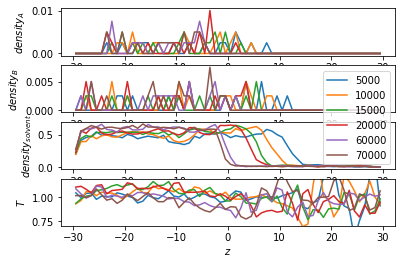

In [2]:
import numpy as np
import gsd.hoomd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(6,8))

# read gsd file
trajectory = gsd.hoomd.open(name='tutorial_02_explicit_evaporation_trajectory.gsd')

for frame in trajectory:
    # density
    pos = frame.particles.position
    box = frame.configuration.box[0:3]
    hist, bins = np.histogram(pos[:,2],bins=50,range=(-0.5*box[2],0.5*box[2]))
    center = (bins[:-1] + bins[1:]) / 2
    binsize = bins[1]-bins[0]
    volume_bin = binsize*box[0]*box[1]
    ax[0].plot(center,hist/volume_bin,label=frame.configuration.step)

    # temperature in each bin
    temp = np.zeros(len(center))
    for i,c in enumerate(center):
        slab_vel = frame.particles.velocity[np.abs(pos[:,2]-c)<binsize]
        l = len(slab_vel)
        if l>0:
            v_squared = slab_vel[:,0]**2 + slab_vel[:,1]**2 + slab_vel[:,2]**2
            T = 1/(3*l)*np.sum(v_squared)
        else:
            T=0
        temp[i]=T
    ax[1].plot(center,temp,label=frame.configuration.step)


ax[1].set_xlabel('$z$')
ax[0].set_ylabel(r'$\rho$')
ax[1].set_ylabel(r'$T$')
ax[0].legend()
plt.show()

The histograms are fairly noisy and you should repeat the same simulation with different seeds and then average them for better statistics. For this set of parameters and initial film height, no significant evaporative cooling or accumulation can be observed. 

We can also check the flux during the simulation by monitoring the number of solvent particles:

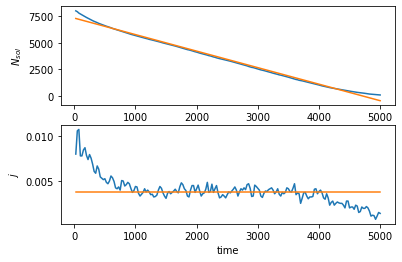

In [3]:
# reading momentum exchange
data = np.genfromtxt('tutorial_evaporation_explicit.txt')

# plotting 
fig, ax = plt.subplots(2)
    
dt= 0.005
L = 20.0
t = data[:,0]*dt
ax[0].plot(t, data[:,1])

z = np.polyfit(t, data[:,1], 1)

ax[0].plot(t, z[0]*t+z[1])

ax[0].set_xlabel('time')
ax[0].set_ylabel('$N_{sol}$')

flux = -np.gradient(data[:,1],data[:,0])/(L**2*dt)

ax[1].plot(t, flux)
ax[1].plot(t, -z[0]*np.ones(len(t))/L**2)
ax[1].set_xlabel('time')
ax[1].set_ylabel('$j$')
plt.show()


After a quick initial evaporation, the flux is roughly constant. Because we did not calculate the diffusion constant for this tutorial, we can't determine the Peclet number. To determine the diffusion constant, we could measure the long term mean-squared displacement. 

## Further reading

- Stratification Dynamics in Drying Colloidal Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b00543

- Stratification in Drying Polymer–Polymer and Colloid–Polymer Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b02074

- Influence of hydrodynamic interactions on stratification in drying mixtures https://aip.scitation.org/doi/full/10.1063/1.5031789
